# Demonstrating AdversarialEnv with FGSM attacks on AlexNet

Imports.

In [1]:
import re
from collections import OrderedDict
import time
import numpy as np

# Pretrained AlexNet for target model.
# You'll have to clone bearpaw's pytorch-classification
# repo and put it in your path to get this example running
import sys
bearpaw_clone = '../pytorch-classification/'
sys.path.append(bearpaw_clone)
from models.cifar.alexnet import alexnet

# Torch goodies
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, ToPILImage, Resize
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, sampler
from torch.autograd import Variable

In [2]:
from PytorchAdversarialGym import AdvEnv, Untargeted

This is needed due to a quirk in the way the keys of the AlexNet state dictionary from `pytorch-classification` were serialized (likely due to an old version of PyTorch).  You can download the `alexnet.pth.tar` weights from [Wei's OneDrive](https://mycuhk-my.sharepoint.com/personal/1155056070_link_cuhk_edu_hk/_layouts/15/guestaccess.aspx?folderid=0a380d1fece1443f0a2831b761df31905&authkey=Ac5yBC-FSE4oUJZ2Lsx7I5c) (but do so at your own risk!).

In [3]:
loaded = torch.load('../pytorch-classification/alexnet.pth.tar')
state = loaded['state_dict']
mod_state = OrderedDict()
for key in list(state.keys()):
    mod_key = re.sub('module.', '', key)
    mod_state[mod_key] = state[key]
target_model = alexnet()
target_model.load_state_dict(mod_state)

We need a dataset to use for attacking.  We'd like to (roughly) compare our results to those found in [Goodfellow et al.](https://arxiv.org/abs/1412.6572), so we'll use CIFAR10.

In [4]:
dataset = CIFAR10(bearpaw_clone+'data/', train = True, download = False, transform = ToTensor())
classes_cifar = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
                 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

We'll use all defaults except for two: `batch_size` and `norm`.  Since we'll be using CUDA, it makes sense to process attacks in batches for efficiency, and we'll set the norm to show how the current reward function works.  Remember, you can create your own reward functions using a `gym.Wrapper` that overrides the `_get_reward` method.

In [5]:
env = AdvEnv(target_model, dataset, batch_size = 32, episode_length = None,
                sampler = None, num_workers = 0, use_cuda = torch.cuda.is_available(), seed = None)
env = Untargeted(env, norm = None, out_function = torch.nn.functional.sigmoid)

Time to create the attack.  FGSM is a white-box attack, so we'll be using gradients from the `target_model` to generate examples.

In [6]:
def run_fgm(state, epsilon, p = float('inf')):
    # States are (image, label) pairs
    img, label = tuple(state)

    # Requires_grad flag needed to compute the gradient 
    # with respect to the input image
    img_var = Variable(img, requires_grad = True)
    if not env.use_cuda:
        img_var = img_var.cpu()

    # Forward/backward pass through target_model
    out = target_model(img_var)
    label_var = Variable(label)
    if env.use_cuda:
        label_var = label_var.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(out, label_var)
    loss.backward()

    # For FGSM, we use the sign of the gradient and scale
    # by epsilon
    if p == float('inf'):
        action = img + epsilon * torch.sign(img_var.grad.data)

    # For generalized FGM, we normalize the gradient with 
    # an L-p norm and scale by epsilon
    else:
        norm = env.norm_on_batch(img_var.grad.data, p = p).view(-1,1,1,1).expand_as(img_var)
        action = img + epsilon * img_var.grad.data / norm

    # Ensure each perturbed image is a valid action in 
    # the environment's action space
    action = torch.clamp(action, 0, 1)

    return action

This is the main attack loop.  It should look familiar if you've worked with OpenAI Gym for reinforcement learning.

In [7]:
# Reset environment to get the initial state
state = env.reset()
done = env.unwrapped.done

# Initiate storage for later
states = [state]
actions = []
rewards = []
norms = []
outcomes = []
infos = []

# Main loop
while not done:
    # Create attack batch
    action = run_fgm(state, .1, float('inf'))

    # Take a step in the environment.
    successor, reward, done, info = env.step(action)
    # The target model classifies our attack batch and computes a 
    # reward for each image in the batch based on the attack's success.
    # It also outputs a dictionary containing details about the attack,
    # which can be useful for monitoring and debugging more sophisticated
    # attacks

    # We'll store these experiences for later evaluation
    states.append(successor)
    actions.append(action)
    rewards.append(reward)
    norms.append(info['norm'])
    success = (info['prediction'] != info['label'])
    outcomes.append(success)
    infos.append(info)

    # Continue the feedback loop
    state = successor

Transform stored experiences and stats into Tensors for conveniently computing evaluation metrics.

In [8]:
states = torch.cat(tuple(map(lambda state: state[0], states)))
actions = torch.cat(tuple(actions))
rewards = torch.cat(tuple(rewards))
if env.norm is not None:
    norms = torch.cat(tuple(norms))
outcomes = torch.cat(tuple(outcomes))
labels = torch.cat(tuple(map(lambda info: info['label'], infos)))

Evaluation metrics.  Goodfellow et al. reported a fool rate of 87.15% and an average confidence of 96.6%.
Our fool rate is likely better and average confidence slightly worse because their benchmark is against a maxout network, which is a much better classifier than the AlexNet we use here.

In [9]:
print('Fool rate: ', sum(outcomes)/len(outcomes))
print('Average Confidence of Misclassified Examples: ', sum([x for x in rewards if x > 0])/len(rewards))
print('Average Reward: ', sum(rewards)/len(rewards))
print('Max Reward: ', max(rewards))
print('Min Reward: ', min(rewards))
# For some attacks, the norm of the perturbation will
# not be known a priori, and manual control over the
# magnitude of the perturbation is not desired.
# We subtract a weighted version of the norm in the reward function
# to account for these situations, and return a tensor of the norms
# for each batch.
if env.norm is not None:
    print('Average Norm', sum(norms)/len(norms))
    print('Max Norm ', max(norms))

Fool rate:  0.9662692061459667
Average Confidence of Misclassified Examples:  0.959344627296316
Average Reward:  0.9260972012573717
Max Reward:  0.9999926090240479
Min Reward:  -0.9984315037727356


In [10]:
preds = torch.cat(tuple(info['prediction'] for info in infos))
preds = np.array(preds)
sums = {}
avgs = {}
for x in np.unique(preds):
    sums[x] = np.sum(preds==x)
    avgs[x] = sums[x]/len(preds)

Interestingly, untargeted attacks tend to push the network towards certain classes more than others.

In [11]:
print('Distribution of predictions')
for key in avgs:
    print('{}: {}'.format(classes_cifar[key], avgs[key]))

Distribution of predictions
airplane: 0.004801536491677336
bird: 0.12504001280409732
cat: 0.0766845390524968
deer: 0.7790092829705506
dog: 0.0053417093469910375
frog: 0.0044014084507042256
ship: 0.004721510883482715


Helper to display some examples.

In [12]:
def convert_to_grid(ix):
    to_pil = ToPILImage()
    state = states[ix].squeeze().cpu()
    action = actions[ix].squeeze().cpu()
    difference = action - state
    grid = make_grid([state, action, difference], nrow = 3)
    img = to_pil(grid)
    size = img.size
    size = (img.size[1]*3, img.size[0]*3)
    resized = Resize(size)(img)
    print('Ground truth: ', classes_cifar[labels[ix]])
    print('Prediction: ', classes_cifar[preds[ix]])
    print('Reward: ',rewards[ix])
    print('Magnitude of Perturbation: ',torch.max(difference))
    return resized

Ground truth:  truck
Prediction:  deer
Reward:  0.9997065663337708
Magnitude of Perturbation:  0.10000002384185791


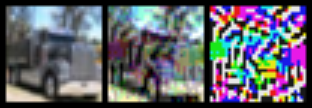

In [13]:
convert_to_grid(5)

Ground truth:  automobile
Prediction:  deer
Reward:  0.9983609318733215
Magnitude of Perturbation:  0.10000002384185791


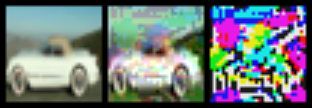

In [14]:
convert_to_grid(1000)

Ground truth:  bird
Prediction:  deer
Reward:  0.9960886240005493
Magnitude of Perturbation:  0.10000002384185791


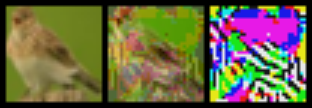

In [15]:
convert_to_grid(5000)